In [1]:
import skimage
import glob
import cv2
import os
import shutil
import skimage
import numpy as np
import pandas as pd

from skimage.io import imread, imsave

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_paths = glob.glob('../input/stage1_train/*/images/*.png')
train_shapes = []
for path in image_paths:
    img = cv2.imread(path)
#     img = skimage.io.imread(path)
    train_shapes.append(img.shape)
pd.Series(train_shapes).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
dtype: int64

In [3]:
image_paths = glob.glob('../input/stage1_test/*/images/*.png')
test_shapes = []
for path in image_paths:
    img = cv2.imread(path)
#     img = skimage.io.imread(path)
    test_shapes.append(img.shape)
pd.Series(test_shapes).value_counts()

(256, 256, 3)    24
(512, 640, 3)     8
(512, 680, 3)     8
(260, 347, 3)     4
(520, 696, 3)     4
(520, 348, 3)     4
(519, 253, 3)     4
(524, 348, 3)     4
(519, 161, 3)     2
(519, 162, 3)     2
(390, 239, 3)     1
dtype: int64

### image type

In [4]:
# 0 - staining;
# 1 - fluorescent microscopy;
# 2 - brightfield microscopy;
type_names = {0: "staining", 1: "fluorescent", 2: "brightfield"}

def get_violet_num(img):
    violet_num = 0
    h, w = img.shape[:2]
    for y in range(h):
        for x in range(w):
            if img[y, x][0] > img[y, x][1] and img[y, x][2] > img[y, x][1]:
                violet_num += 1

    return violet_num

def get_microscopy_type(img):
    violet_num = get_violet_num(img)
    if violet_num > 0:
        return 0
    mean_int = img.mean()
    # randomly picked threshold for distinquishing fluorescent and brightfield
    if mean_int > 100:
        return 2
    return 1

### calculating nuclei size

In [5]:
image_ids, image_shapes, image_types, num_of_cells, cell_areas, mean_area, nuclei_size = [], [], [], [], [], [], []
shape_hs, shape_ws = [], []
image_paths = glob.glob('../input/stage1_train/*')
print('Total number of training samples: ' + str(len(image_paths)))

Total number of training samples: 670


In [6]:
counter = 0
for path in image_paths:
    counter += 1
    if counter % 100 == 0:
        print(counter)
    image_id = path.split('/')[-1]
    image_ids.append(image_id)
    
    # image shape and type
    img = cv2.imread(path + '/images/' + image_id + '.png')
    image_shapes.append(list(img.shape))
    shape_hs.append(img.shape[0])
    shape_ws.append(img.shape[1])
    img_type = get_microscopy_type(img)
    image_types.append(img_type)
    
    # mask info
    masks = glob.glob(path + '/masks/' + '/*.png')
    num_of_cells.append(len(masks))
    areas = []
    for mask in masks:
        mask = cv2.imread(mask)
        mask = mask[:, :, 0]
        mask = (mask > 0).astype(np.int8)
        area = np.sum(mask)
        areas.append(area)
        
    cell_areas.append(areas)
    m_area = np.mean(areas)
    mean_area.append(m_area)
    nuclei_size.append(np.sqrt(m_area))

100
200
300
400
500
600


In [7]:
df = pd.DataFrame(list(zip(image_ids, image_shapes, shape_hs, shape_ws, image_types, 
                           num_of_cells, cell_areas, mean_area, nuclei_size)), 
                 columns = ['ImageId', 'Shape', 'ShapeH', 'ShapeW', 'Type', 
                            'NumCells', 'CellAreas', 'MeanArea', 'NucleiSize'])

In [8]:
df['RatioH'] = df.apply(lambda row: row['NucleiSize'] / row['ShapeH'], axis=1)
df['RatioW'] = df.apply(lambda row: row['NucleiSize'] / row['ShapeW'], axis=1)

In [9]:
df.head()

,ImageId,Shape,ShapeH,ShapeW,Type,NumCells,CellAreas,MeanArea,NucleiSize,RatioH,RatioW
0,45c3bdef1819ba7029990e159f61543ed25781d13fb4dc...,"[520, 696, 3]",520,696,1,8,"[269, 1553, 3084, 2575, 359, 817, 3408, 121]",1523.250000,39.028835,0.075055,0.056076
1,7c0157913223365720209ac83ff2e0b1b2b460173acd61...,"[360, 360, 3]",360,360,1,25,"[3646, 2915, 1208, 537, 605, 2726, 2583, 3674,...",1829.880000,42.777097,0.118825,0.118825
2,d2815f2f616d92be35c7e8dcfe592deec88516aef9ffc9...,"[256, 256, 3]",256,256,1,14,"[327, 84, 270, 213, 279, 269, 156, 66, 232, 10...",189.928571,13.781458,0.053834,0.053834
3,76a372bfd3fad3ea30cb163b560e52607a8281f5b04248...,"[1024, 1024, 3]",1024,1024,2,63,"[174, 642, 281, 52, 89, 35, 505, 140, 82, 487,...",247.190476,15.722292,0.015354,0.015354
4,3d0ca3498d97edebd28dbc7035eced40baa4af199af09c...,"[256, 256, 3]",256,256,1,4,"[175, 142, 244, 48]",152.250000,12.338963,0.048199,0.048199


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 11 columns):
ImageId       670 non-null object
Shape         670 non-null object
ShapeH        670 non-null int64
ShapeW        670 non-null int64
Type          670 non-null int64
NumCells      670 non-null int64
CellAreas     670 non-null object
MeanArea      670 non-null float64
NucleiSize    670 non-null float64
RatioH        670 non-null float64
RatioW        670 non-null float64
dtypes: float64(4), int64(4), object(3)
memory usage: 57.7+ KB


In [11]:
# df.to_csv('../output/training_df_info.csv', index=False)

In [12]:
df.Type.value_counts()

1    546
0    108
2     16
Name: Type, dtype: int64

### resizing

In [13]:
df = pd.read_csv('../output/training_df_info.csv')

(array([430., 136.,  49.,  31.,   9.,   6.,   4.,   2.,   1.,   2.]),
 array([  1. ,  38.4,  75.8, 113.2, 150.6, 188. , 225.4, 262.8, 300.2,
        337.6, 375. ]),
 <a list of 10 Patch objects>)

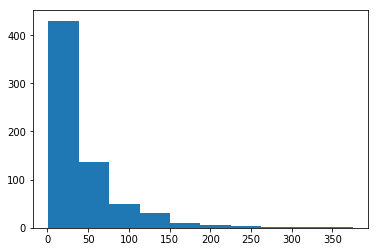

In [14]:
plt.hist(df['NumCells'])

(array([222., 225.,  65.,  52.,  95.,   9.,   1.,   0.,   0.,   1.]),
 array([ 5.09901951, 13.10032866, 21.1016378 , 29.10294694, 37.10425608,
        45.10556523, 53.10687437, 61.10818351, 69.10949265, 77.1108018 ,
        85.11211094]),
 <a list of 10 Patch objects>)

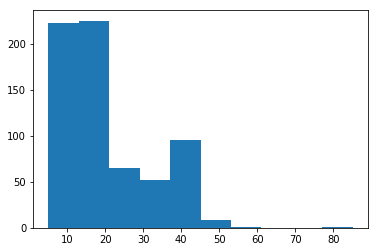

In [15]:
plt.hist(df['NucleiSize'])

In [16]:
np.mean(df['NucleiSize'])

20.774878502288406

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 11 columns):
ImageId       670 non-null object
Shape         670 non-null object
ShapeH        670 non-null int64
ShapeW        670 non-null int64
Type          670 non-null int64
NumCells      670 non-null int64
CellAreas     670 non-null object
MeanArea      670 non-null float64
NucleiSize    670 non-null float64
RatioH        670 non-null float64
RatioW        670 non-null float64
dtypes: float64(4), int64(4), object(3)
memory usage: 57.7+ KB


In [32]:
def resize_shape(row, target_nuclei_size=20):    
    ratio = target_nuclei_size / row['NucleiSize']
    shape = list(row['Shape'])
    h, w, c = shape[0], shape[1], shape[2]
    rh, rw = 2*round(h*ratio/2), 2*round(w*ratio/2)
    return [rh, rw, c]

In [33]:
df['ResizeShape'] = df.apply(resize_shape, axis=1)
df['ResizeH'] = df.apply(lambda row: resize_shape(row)[0], axis=1)
df['ResizeW'] = df.apply(lambda row: resize_shape(row)[1], axis=1)

In [34]:
df.head()

,ImageId,Shape,ShapeH,ShapeW,Type,NumCells,CellAreas,MeanArea,NucleiSize,RatioH,RatioW,ResizeShape,ResizeH,ResizeW
0,45c3bdef1819ba7029990e159f61543ed25781d13fb4dc...,"[520, 696, 3]",520,696,1,8,"[269, 1553, 3084, 2575, 359, 817, 3408, 121]",1523.250000,39.028835,0.075055,0.056076,"[266, 356, 3]",266,356
1,7c0157913223365720209ac83ff2e0b1b2b460173acd61...,"[360, 360, 3]",360,360,1,25,"[3646, 2915, 1208, 537, 605, 2726, 2583, 3674,...",1829.880000,42.777097,0.118825,0.118825,"[168, 168, 3]",168,168
2,d2815f2f616d92be35c7e8dcfe592deec88516aef9ffc9...,"[256, 256, 3]",256,256,1,14,"[327, 84, 270, 213, 279, 269, 156, 66, 232, 10...",189.928571,13.781458,0.053834,0.053834,"[372, 372, 3]",372,372
3,76a372bfd3fad3ea30cb163b560e52607a8281f5b04248...,"[1024, 1024, 3]",1024,1024,2,63,"[174, 642, 281, 52, 89, 35, 505, 140, 82, 487,...",247.190476,15.722292,0.015354,0.015354,"[1302, 1302, 3]",1302,1302
4,3d0ca3498d97edebd28dbc7035eced40baa4af199af09c...,"[256, 256, 3]",256,256,1,4,"[175, 142, 244, 48]",152.250000,12.338963,0.048199,0.048199,"[414, 414, 3]",414,414


In [35]:
df.to_csv('../output/training_df_resize_info.csv', index=False)